<a href="https://colab.research.google.com/github/youcy8585/scrapping_darkpattern/blob/develop/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas beautifulsoup4 lxml

In [ ]:
import pandas as pd
from google.colab import drive
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os

In [ ]:
# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. CSV 파일 경로 설정 (구글 드라이브 내 경로)
file_path = '/content/drive/MyDrive/Colab Notebooks/example.CSV'

In [ ]:
# CSV 파일을 읽고 열 이름 출력
df = pd.read_csv(file_path, encoding='ISO-8859-1')
print("열 이름:", df.columns)

열 이름: Index(['HTML', 'CSS', 'Matched Keywords', 'Dark Pattern'], dtype='object')


In [ ]:
# 파일 존재 여부 확인
if os.path.exists(file_path):
    print("파일이 존재합니다.")
else:
    print("파일이 존재하지 않습니다. 경로를 확인하세요.")

파일이 존재합니다.


In [ ]:
# 4. CSV 파일에서 HTML 및 CSS 코드를 전처리하는 함수
def process_data_from_csv(file_path):
    # CSV 파일 불러오기 (인코딩 지정)
    df = pd.read_csv(file_path, encoding='ISO-8859-1') # UTF-8 인코딩이 아닌 파일의 인코딩을 설정

    # 데이터 전처리 결과를 저장할 리스트
    processed_data = []  # 전처리된 데이터를 저장할 빈 리스트로 나중에 각 HTML 태그의 정보가 저장

    # 각 행에 대해 처리
    for index, row in df.iterrows():
        html_code = row['HTML']
        css_code = row['CSS']
        keyword = row['Matched Keywords']
        dark_pattern = row['Dark Pattern']

        # HTML 코드가 NaN이 아닌 경우에만 처리
        if pd.notna(html_code):
            # BeautifulSoup으로 HTML 코드 파싱
            soup = BeautifulSoup(html_code, 'lxml')

            # HTML 태그를 계층적으로 파싱하는 함수
            def parse_tag(tag, parent_tag=None, depth=0):
                tag_info = {
                    'tag': tag.name,  # 현재 처리 중인 HTML 태그
                    'parent': parent_tag.name if parent_tag else 'None',  # 현재 태그의 부모 태그(기본값은 None)
                    'depth': depth,  # 현재 태그의 깊이
                    'keyword': keyword,  # CSV 파일에서 각 행에 대해 읽어온 "Matched Keywords" 열의 값을 저장
                    'dark_pattern': dark_pattern  # 다크패턴 여부 판단
                }
                processed_data.append(tag_info)

                for child in tag.find_all(recursive=False): # recursive=False는 직접적인 자식 태그만 탐색
                    parse_tag(child, tag, depth + 1)  # 현재 태그의 모든 자식 태그를 찾아서, parse_tag 함수를 재귀적으로 호출하여 자식 태그를 처리

            # HTML 문서의 최상위 태그(html)부터 파싱 시작
            if soup.html:  # HTML 태그가 존재하는 경우만 처리
                parse_tag(soup.html)

    return processed_data  # 전처리 결과 반환

In [ ]:
def visualize_data_distribution_3d(data):
    # 태그 이름, 깊이, 다크 패턴 여부를 기반으로 3D 시각화
    tag_names = [d['tag'] for d in data]
    depths = [d['depth'] for d in data]
    dark_patterns = [1 if d['dark_pattern'] == 'O' else 0 for d in data]

    # 태그 이름을 인덱스로 변환
    unique_tags = list(set(tag_names))  # 고유한 태그 목록
    tag_indices = [unique_tags.index(tag) for tag in tag_names]  # 각 태그의 인덱스

    # 고유 태그 수 및 태그 목록 출력
    print(f"총 고유 태그 수: {len(unique_tags)}")
    print("고유 태그 목록:")
    for tag in unique_tags:
        print(tag)

    # 3D 시각화
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 색상 설정 (다크 패턴 여부에 따라 색상 변경)
    colors = ['r' if dp == 1 else 'b' for dp in dark_patterns]

    ax.scatter(tag_indices, depths, dark_patterns, c=colors, alpha=0.6)  # x축에는 태그 인덱스, y축에는 깊이, z축에는 다크패턴 여부를 표시

    ax.set_xlabel('Tag Indices')
    ax.set_ylabel('Depth')
    ax.set_zlabel('Dark Pattern (1: Yes, 0: No)')
    ax.set_title('3D Distribution of HTML Tags and Dark Patterns')

    # 고유 태그 수에 맞춰 x축 레이블 설정
    ax.set_xticks(range(len(unique_tags)))  # x축 위치 설정
    ax.set_xticklabels(unique_tags, rotation=90)  # 태그 이름으로 x축 레이블 설정
    plt.show()


처리된 데이터 개수: 12341
총 고유 태그 수: 47
고유 태그 목록:
option
style
div
a
body
caption
th
col
dl
h2
b
dt
table
h1
script
html
circle
g
path
br
h5
use
svg
h4
p
select
dd
h3
button
ol
i
span
td
tr
strong
footer
form
label
input
li
em
del
mask
colgroup
noscript
img
ul


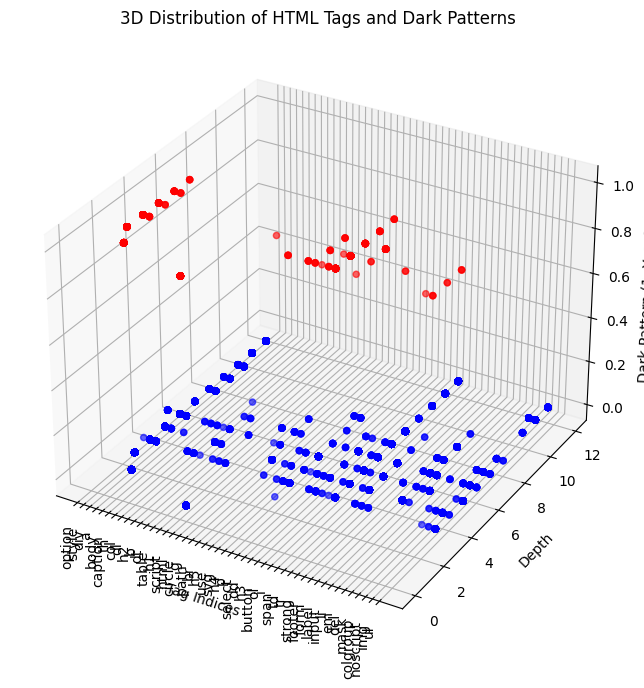

In [ ]:
# 파일이 존재할 경우에만 실행
if os.path.exists(file_path):
    processed_data = process_data_from_csv(file_path)

    # 결과 확인 및 시각화
    if processed_data:
        print(f"처리된 데이터 개수: {len(processed_data)}")
        visualize_data_distribution_3d(processed_data)